In [1]:
import MRI_coil
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import to_hex
from stl import mesh
import magpylib as magpy
from scipy.optimize import curve_fit

## Single loop coil

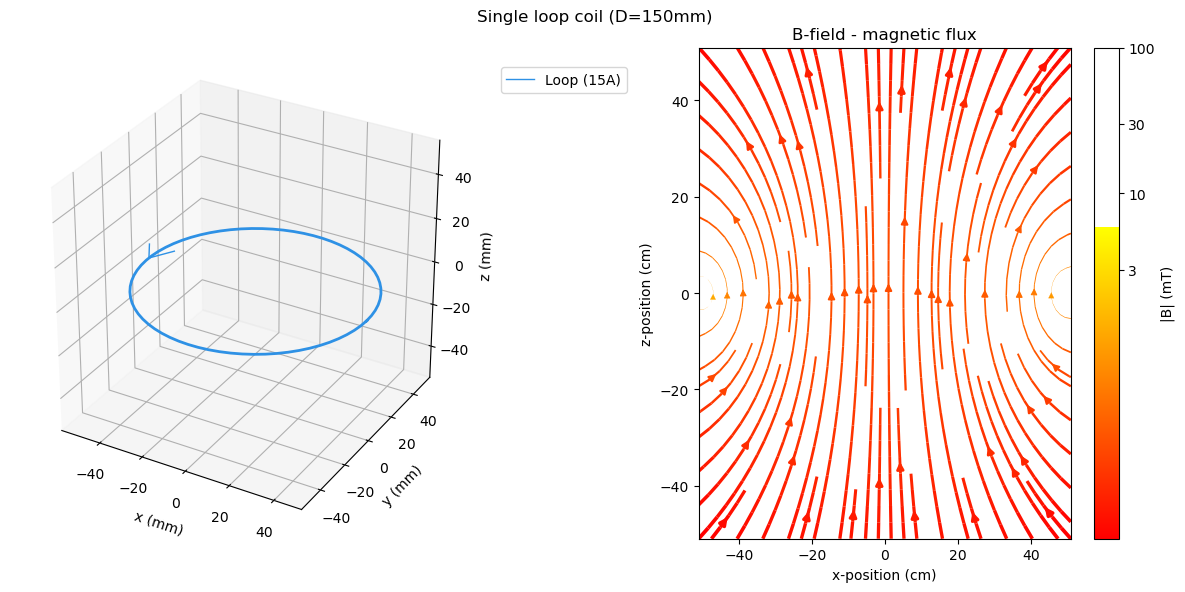

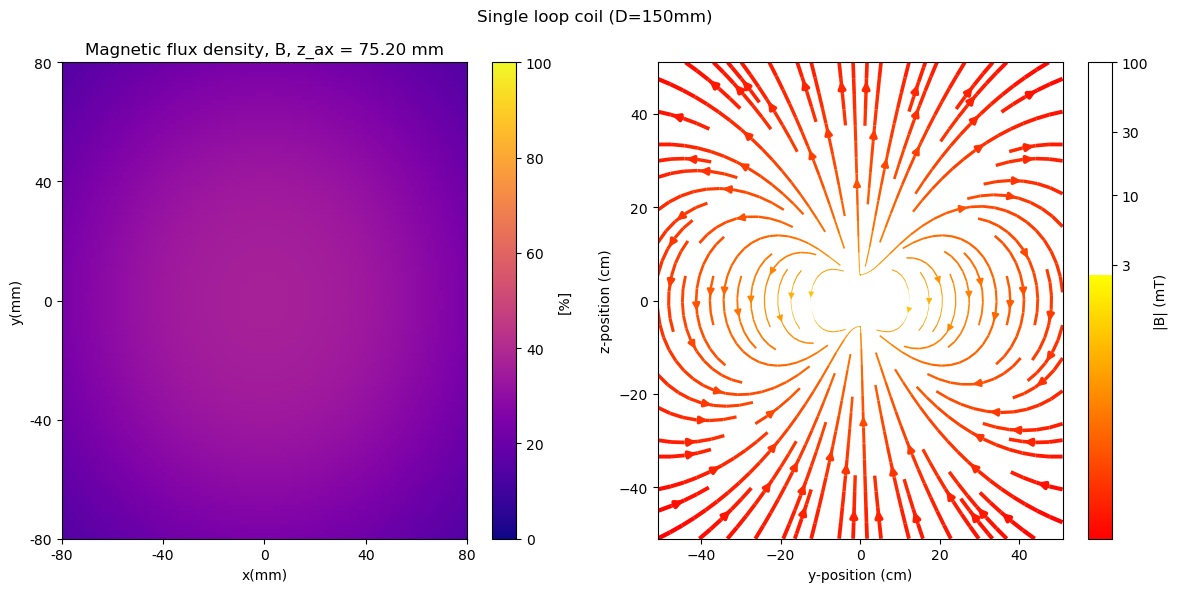

In [2]:
single_loop_coil = MRI_coil.MRI_coil(15, 100)
fig1 = plt.figure(figsize=[12, 6])
fig1.suptitle("Single loop coil (D=150mm)")
ax1 = fig1.add_subplot(1,2,1, projection="3d")
ax2 = fig1.add_subplot(1,2,2) 
single_loop_coil.show_coil(ax=ax1)
single_loop_coil.show_field_lines(slice="x50", ax=ax2, fig=fig1)
ax2.set_title("B-field - magnetic flux")
plt.show()

fig1 = plt.figure(figsize=[12, 6])
fig1.suptitle("Single loop coil (D=150mm)")
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2) 
single_loop_coil.show_field_slice("B", slice=97, ax=ax1)
single_loop_coil.show_field_lines(slice="y99", ax=ax2, fig=fig1)
#single_loop_coil.show_field_magnitude("B", gif_name="norm_to_mid_val.mp4")

# single_loop_coil.show_field_slice("B", slice=50, verbose=True)
# single_loop_coil.show_field_slice("B", slice=97, verbose=True)
# single_loop_coil.show_field_slice("B", slice=2, verbose=True)

## Quadrature coil

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


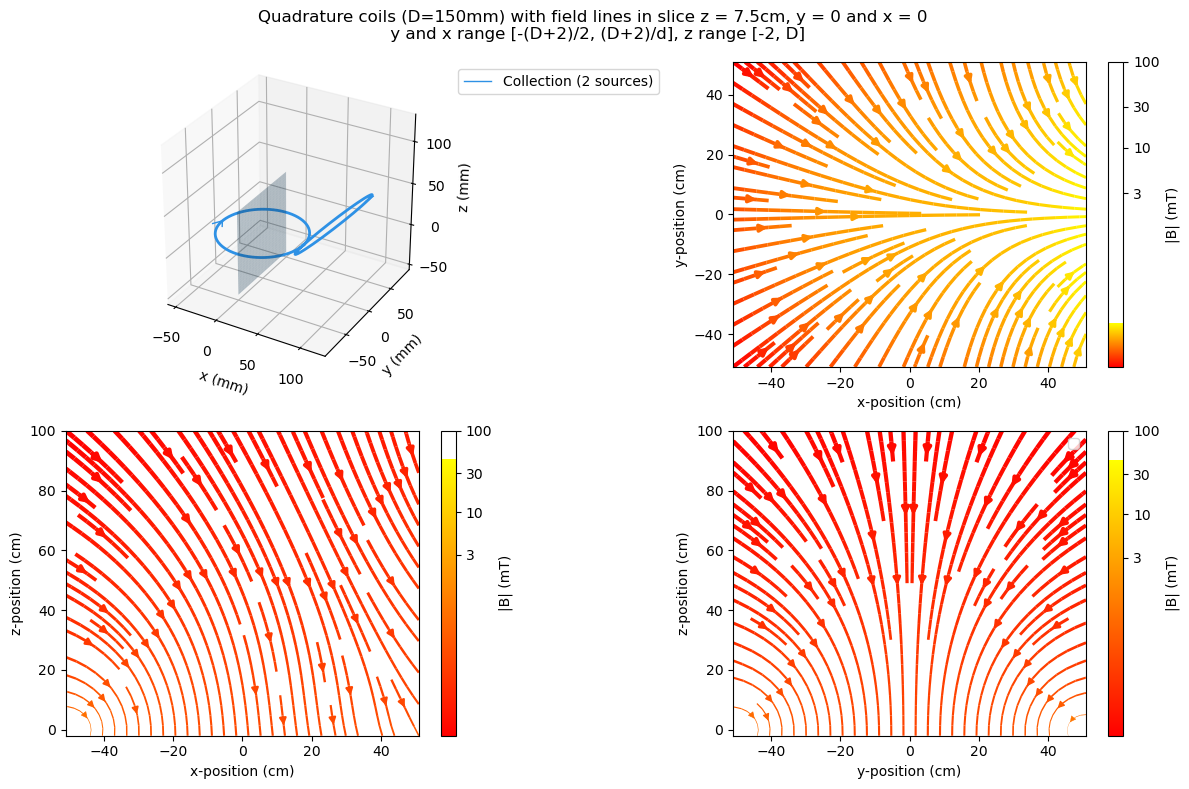

In [5]:
def plane_at(slice="x=00", extent=50):
    xx = np.linspace(-extent, extent, 101)
    zz = np.linspace(-extent, extent, 101)
    yy = np.linspace(-extent, extent, 101)
    if slice[0]=="x":
        Y, Z = np.meshgrid(yy, zz)
        X = np.ones_like(Y)*int(slice[-2:])
    elif slice[0]=="y":
        X, Z = np.meshgrid(xx, zz)
        Y = np.ones_like(X)*int(slice[-2:])
    elif slice[0]=="z":
        X, Y = np.meshgrid(xx, yy)
        Z = np.ones_like(X)*int(slice[-2:])
    return X, Y, Z
quad_coil = MRI_coil.MRI_coil(15, 100, quadrature=True, quad_dir="out")
# PLOTTING 3D MODEL AND 3 DIFFERENT SLICES WITH FIELD LINES #
fig2 = plt.figure(figsize=[12, 8])
fig2.suptitle("Quadrature coils (D=150mm) with field lines in slice z = 7.5cm, y = 0 and x = 0 \n y and x range [-(D+2)/2, (D+2)/d], z range [-2, D]")
ax1 = fig2.add_subplot(2,2,1, projection="3d")
ax2 = fig2.add_subplot(2,2,2)
ax3 = fig2.add_subplot(2,2,3)
ax4 = fig2.add_subplot(2,2,4)
quad_coil.show_coil(ax=ax1)
quad_coil.show_field_lines(slice="z56", ax=ax2, fig=fig2)
quad_coil.show_field_lines(slice="x50", ax=ax3, fig=fig2)
quad_coil.show_field_lines(slice="y50", ax=ax4, fig=fig2)
extent = (quad_coil.diameter+2)/2
X, Y, Z = plane_at("x=00")
ax1.plot_surface(X, Y, Z, alpha=.3, label="y = 0, slice 50")
plt.legend()
plt.show()
# quad_coil.show_field_magnitude("B", vmax=200) #, gif_name="quad_norm_to_mid_val.mp4")
# # TODO: Still lacking a proper calculation of actual field strength in Tesla... (percentage may not be so cool, or is this really necessary?)

## Specialized coil

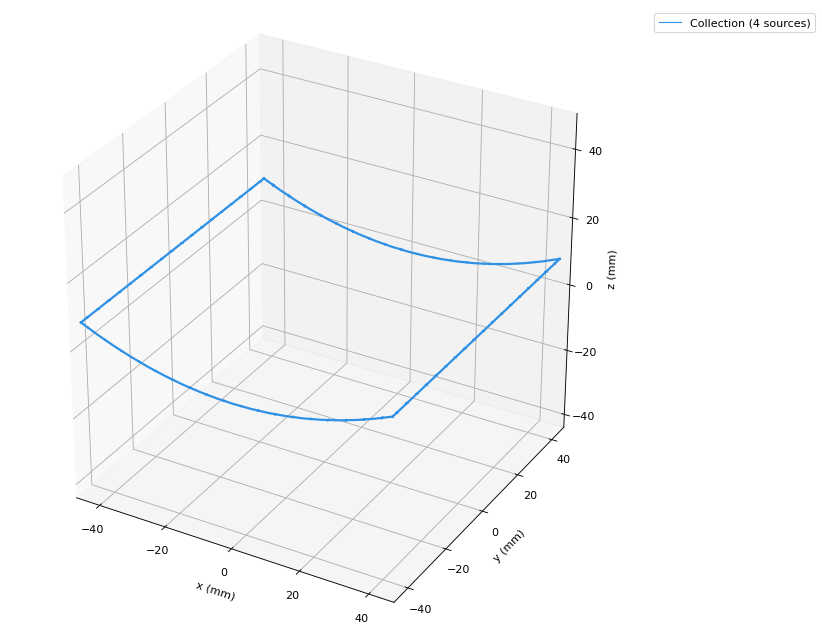

In [7]:
def bin_color_to_hex(x):
    """
    transform binary rgb into hex color
    source: https://magpylib.readthedocs.io/en/latest/_pages/docu/docu_graphics.html
    """
    sb = f"{x:015b}"[::-1]
    r = int(sb[:5], base=2) / 31
    g = int(sb[5:10], base=2) / 31
    b = int(sb[10:15], base=2) / 31
    return to_hex((r, g, b))

def trace_from_stl(stl_file, x_coords_current=None):
    """
    Generates a Magpylib 3D model trace dictionary from an *.stl file.
    backend: 'matplotlib' or 'plotly'
    source: https://magpylib.readthedocs.io/en/latest/_pages/docu/docu_graphics.html
    """
    # load stl file
    stl_mesh = mesh.Mesh.from_file(stl_file)

    # extract vertices and triangulation
    p, q, r = stl_mesh.vectors.shape
    vertices, ixr = np.unique(
        stl_mesh.vectors.reshape(p * q, r), return_inverse=True, axis=0
    )
    i = np.take(ixr, [3 * k for k in range(p)])
    j = np.take(ixr, [3 * k + 1 for k in range(p)])
    k = np.take(ixr, [3 * k + 2 for k in range(p)])
    x, y, z = vertices.T

    # generate and return a generic trace which can be translated into any backend
    colors = stl_mesh.attr.flatten()
    facecolor = np.array([bin_color_to_hex(c) for c in colors]).T
    trace = {
        "backend": "generic",
        "constructor": "mesh3d",
        "kwargs": dict(x=x, y=y, z=z, i=i, j=j, k=k, facecolor=facecolor),
    }
    if len(x_coords_current) > 0:
        # Extract coordinates of current line along x-axis
        idx = []
        for x1 in x_coords_current:
            idx_x = np.where(np.round(x, 0)==x1)[0]
            if len(idx_x)>0:
                ys_to_see = y[idx_x]
                #print(ys_to_see)
                idx_y = np.where(ys_to_see == 0.)[0]
                if len(idx_y)>0:
                    for i in idx_x[idx_y]:
                        idx.append(i)
        return trace, vertices[idx]
    return trace

# Want to create a quadratic surface loop with x = [-45, 45] and y = [-45, 45] meaning 9 cm side length
xs_curr_arc = np.linspace(-45, 45, 91)

# load stl file from online resource
stl_file_path = "/Users/marialsaker/Library/CloudStorage/OneDrive-UniversityofBergen/Medtek/Master/3Dfiles/Enhancing_holder.stl"
# create trace of mesh and fetch line of current path just below 
trace_mesh3d, curr_line_vertices = trace_from_stl(stl_file_path, xs_curr_arc)
# Initiating the collection and placing it close to origo
Coil_holder = magpy.Collection(position=(0, 0, 100), style_label="'Coil holder' trace")
Coil_holder.style.model3d.add_trace(trace_mesh3d)
curr_line_vertices[:,2] = curr_line_vertices[:,2] +100 # correcting for offset in 3d stl file

#fig3 = plt.figure()
#ax1 = fig3.add_subplot(1,2,1, projection="3d")
# Removing points on support volume
i_to_remove = []
for i, vert in enumerate(curr_line_vertices):
    if(vert[2]<-10):
        i_to_remove.append(i)
        continue
curr_line_vertices = np.delete(curr_line_vertices, i_to_remove, axis=0)

# Removing points above fitted curve
def square(x, a, b):
    return a*x**2 + b
popt, pcov = curve_fit(square, curr_line_vertices[:,0], curr_line_vertices[:,2])
testx = np.linspace(-40, 40, 100)
i_to_remove = []
for i, vert in enumerate(curr_line_vertices):
    if square(vert[0], *popt) < vert[2]:
        i_to_remove.append(i)
curr_line_vertices = np.delete(curr_line_vertices, i_to_remove, axis=0)

# Fit a line to the chosen vertices
popt, pcov = curve_fit(square, curr_line_vertices[:,0], curr_line_vertices[:,2])
xs_curr_arc = np.linspace(-45, 45, 19) # We dont need 91 steps, so i reduce to 19
zs_curr_arc = square(xs_curr_arc, *popt)

vertices_curr_arc_neg = np.concatenate([xs_curr_arc.reshape(len(xs_curr_arc),1), 
                                        np.ones_like(xs_curr_arc).reshape(len(xs_curr_arc),1)*-45, 
                                        zs_curr_arc.reshape(len(xs_curr_arc),1)],axis=1)
vertices_curr_arc_pos = np.concatenate([xs_curr_arc.reshape(len(xs_curr_arc),1), 
                                        np.ones_like(xs_curr_arc).reshape(len(xs_curr_arc),1)*45, 
                                        zs_curr_arc.reshape(len(xs_curr_arc),1)],axis=1)
ys_curr_line = np.linspace(-45, 45, 19).reshape(19,1)
vertices_curr_line_neg =  np.concatenate([np.ones_like(ys_curr_line)*xs_curr_arc[0], 
                                          ys_curr_line, 
                                          np.ones_like(ys_curr_line)*square(xs_curr_arc[0], *popt)], axis=1)
vertices_curr_line_pos =  np.concatenate([np.ones_like(ys_curr_line)*xs_curr_arc[-1], 
                                          ys_curr_line, 
                                          np.ones_like(ys_curr_line)*square(xs_curr_arc[-1], *popt)], axis=1)

cur_arc_neg = magpy.current.Line(100, vertices_curr_arc_neg)
cur_line_pos = magpy.current.Line(100, vertices_curr_line_pos)
cur_arc_pos = magpy.current.Line(100, np.flip(vertices_curr_arc_pos, axis=0))
cur_line_neg = magpy.current.Line(100, np.flip(vertices_curr_line_neg, axis=0))
the_current_lines = np.array([cur_arc_neg, cur_line_pos, cur_arc_pos, cur_line_neg])
the_coil = magpy.Collection((cur_arc_neg, cur_line_pos, cur_arc_pos, cur_line_neg))

special_single_loop = MRI_coil.MRI_coil(current=100, diameter=90, custom_coil=True, custom_coil_current_line=the_coil)
special_single_loop.show_coil(show=True)



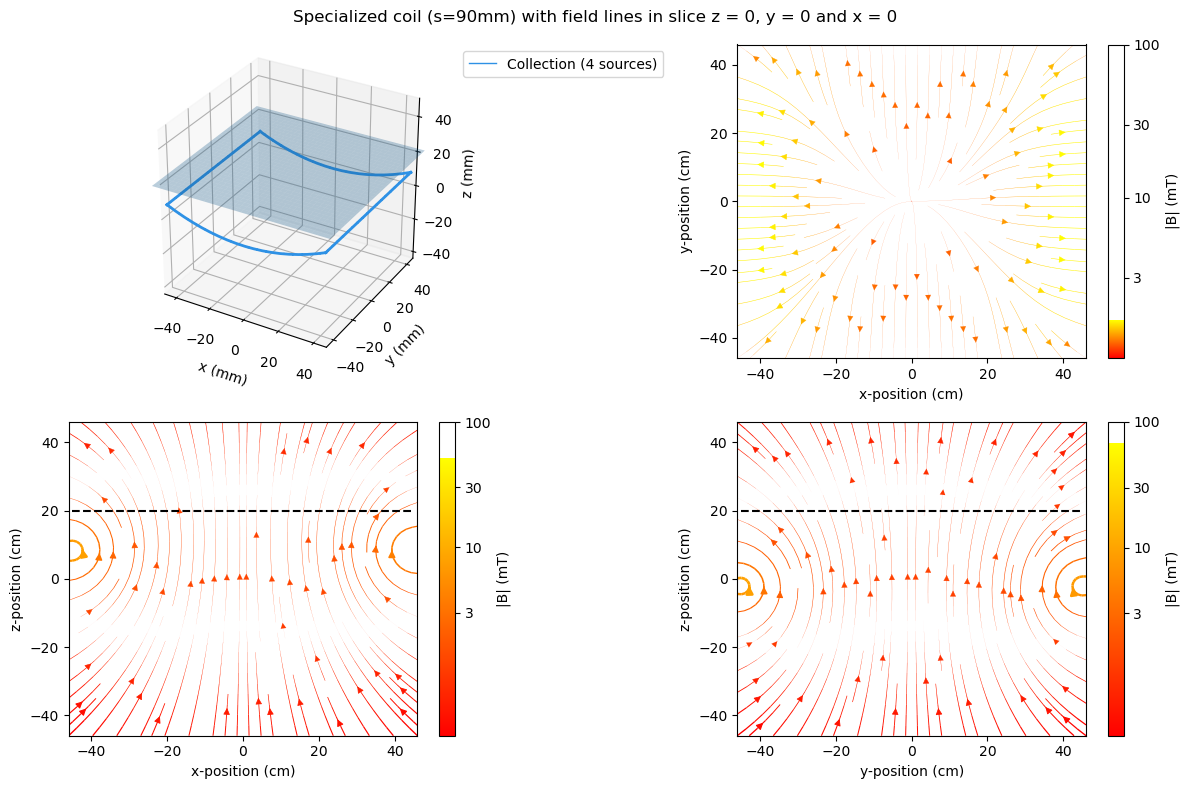

In [6]:
fig2 = plt.figure(figsize=[12, 8])
fig2.suptitle("Specialized coil (s=90mm) with field lines in slice z = 0, y = 0 and x = 0")
ax1 = fig2.add_subplot(2,2,1, projection="3d")
ax2 = fig2.add_subplot(2,2,2)
ax3 = fig2.add_subplot(2,2,3)
ax4 = fig2.add_subplot(2,2,4)
special_single_loop.show_coil(ax=ax1)
#magpy.show(Coil_holder, backend="matplotlib", canvas=ax1)
special_single_loop.show_field_lines(slice="z72", ax=ax2, fig=fig2)
special_single_loop.show_field_lines(slice="x50", ax=ax3, fig=fig2)
ax3.hlines(y=[20], xmin=[-45], xmax=[45], colors=['k'], linestyles='dashed')
special_single_loop.show_field_lines(slice="y50", ax=ax4, fig=fig2)
ax4.hlines(y=[20], xmin=[-45], xmax=[45], colors=['k'], linestyles='dashed')
X, Y, Z = plane_at("z=20")
ax1.plot_surface(X, Y, Z, alpha=.3, label="x = 0, slice 50")
plt.show()